In [25]:
import ee
#import folium
import os
import pandas as pd
import foliumgee
import rasterio as rio
import numpy as np
from rasterio import plot

import datetime as dt
from dateutil.relativedelta import *

from sklearn import preprocessing

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import earthpy as ep
import earthpy.plot as eplot
from matplotlib.transforms import Transform


In [147]:
#ee.Authenticate()
ee.Initialize()

### generate a list of EE dates to search for images

In [7]:
fig_dir = '/Users/corey/Documents/GitHub/jpl_msp_2020/figures'
s2_imdir = '/Users/corey/Google Drive/sentinel_2_rainier'
imdir = '/Users/corey/Documents/GitHub/jpl_msp_2020/data/ecostress_mt_rainier'

labelled = pd.read_csv(os.path.join(imdir, 'labelled_images_rainier.csv'))

qced = labelled[labelled['qc_flag'] ==True]

def normalize(x):
    return ((x - np.nanmin(x)) * (1/(np.nanmax(x) - np.nanmin(x)) * 255)).astype('uint8')



In [17]:
#Parse dates

doy = qced['images'].str.split('/').str[8].str.split('_').str[3].str.replace('doy', '')
doy = pd.to_datetime(doy, format='%Y%j%H%M%S')
qced['doy'] = doy.values
qced = qced.sort_values('doy')

days = doy.dt.day
months = doy.dt.month
years = doy.dt.year

hour = doy.dt.hour
minute = doy.dt.minute
second = doy.dt.second

<ipython-input-17-6013471019a0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qced['doy'] = doy.values


In [ ]:
#Format into list of ee.Date objects
ee_dates = []
for i, d in enumerate(days):
    date_str = str(years.iloc[i])+'-'+str(months.iloc[i])+'-'+str(days.iloc[i])+' '+str(hour.iloc[i])+' '+str(minute.iloc[i])+' '+str(second.iloc[i])
    ee_dates.append(ee.Date.parse('yyyy-MM-DD HH mm ss',date_str))

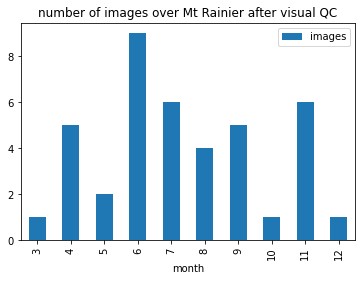

In [27]:
ax = qced['images'].groupby(qced["doy"].dt.month).count().plot(kind="bar", legend="month")
ax.set_xlabel('month')
ax.set_title('number of images over Mt Rainier after visual QC')
plt.savefig(os.path.join(fig_dir, 'mt_rainier_image_count_hist.png'), dpi=300)

### Define a search region and retrieve an image +-5 days of ECOSTRESS and append the least cloud obscured to a list

In [791]:
#Make cloud free mosaics of S2 Images

bands = ['B4', 'B3', 'B2']


region = ee.Geometry.Polygon([[[-121.91748046875, 46.763085924088955],
      [-121.91748046875, 47.020166002213955],
      [-121.568115234375, 47.020166002213955],
      [-121.568115234375, 46.763085924088955],
      [-121.91748046875, 46.763085924088955]]])

#make a list of months for image mosaic creation
month_range = pd.date_range('2019-06-01', '2020-07-01', freq='MS')

def maskclouds(image):
        band_qa = image.select('QA60')
        cloud_mask = ee.Number(2).pow(10).int()
        cirrus_mask = ee.Number(2).pow(11).int()
        mask = band_qa.bitwiseAnd(cloud_mask).eq(0) and(
            band_qa.bitwiseAnd(cirrus_mask).eq(0))
        return image.updateMask(mask).divide(10000).clip(region) #.set('id', image.get('id').getInfo())



#Iterate over list of dates and make a monthly cloud free mosaic 

s2 = ee.ImageCollection("COPERNICUS/S2_SR")

s2_ims = []

for idx, d in enumerate(months):
    try:
        end = month_range[idx+1]
        d = ee.Date(d)
        im = s2.filterBounds(region).filterDate(d, end).map(maskclouds)
        s2_ims.append(im.select(bands).mean().set('date', d.format().getInfo()))
    except:
        pass

    
    

In [165]:
orbitsD.getInfo()

[13, 115]

# Run melt algorithm on Sentinel-1 images in the same region and return a binary image collection of whether or not backscatter from image acquisition at interval t is <winter_mean - 3dB 

In [ ]:
total_region = ee.Geometry.Polygon(
        [[[-122.03371310515053, 46.99124474047179],
          [-122.03371310515053, 46.717488598400486],
          [-121.50705600065834, 46.717488598400486],
          [-121.50705600065834, 46.99124474047179]]])
glims = ee.FeatureCollection("GLIMS/current")

####################################################################
######  Snowmelt onset from Sentinel-1 in Hindu Kush Himalayas ####### 
######                     A final product                     #######  
####################################################################

# --------------Runtime parameters ---------------- #

dryStart = '2019-01-01';
dryEnd = '2019-02-28';

meltStart = '2019-07-01';
meltEnd = '2019-08-30';

studyStart = '2019-01-01';
studyEnd = '2020-01-01';

zLim = -2

band = ['VH']

threshold = 3 #dB

# -------------------------------------------------------------------
# Define region 

glimsMask = ee.Image().paint(glims.filterBounds(total_region), 1).eq(0);

# -------------------------------------------------------------------------------
# Bring in Radar data -----------------------------------------------------------
# ---- Import Sentinel-1 image collection -------
s1 = ee.ImageCollection("COPERNICUS/S1_GRD")

s1 = s1.filterBounds(total_region).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))#.map(maskAngGT30).map(maskAngLT45);

#----Separate S1 by orbit type ---------------------

s1A = s1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
s1D = s1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

# --------------------------------------------------------------------
# Make list of relative orbit numbers
#

def orbs(image):
    image = ee.Image(image);
    start = image.get('relativeOrbitNumber_start');
    return start;


orbitsD = s1D.toList(s1D.size()).map(orbs).distinct();
orbitsA = s1A.toList(s1A.size()).map(orbs).distinct();
print(orbitsD.getInfo());

# orbitsD = ee.List([107,121,122,135,136,150,151,164,165,4,5,19,20,33,34,48,49,62,63,77,78,92,106]);
# orbitsA = ee.List([12,13,26,27,41,42,55,56,70,71,85,86,99,100,114,115,128,129,143,144,158,172,173])


# ----------------------------------------------------------------------
# Functions

#Melt algorithm

def meltAlg(imColl):
    def byOrbit(orbitNumber):

    # Calculate relevant statistics for threshold detection 

        winterMean = imColl.filterDate(dryStart, dryEnd).select(band).filterMetadata('relativeOrbitNumber_start', 'equals', orbitNumber).mean()

        summerMean = imColl.filterDate(meltStart, meltEnd).select(band).filterMetadata('relativeOrbitNumber_start', 'equals', orbitNumber).mean()


        winterStd = imColl.filterDate(dryStart, dryEnd).select(band).filterMetadata('relativeOrbitNumber_start', 'equals', orbitNumber).reduce(ee.Reducer.stdDev())

        #Filter image collection by orbit track

        imCol = imColl.filterDate(studyStart, studyEnd).select(band).filterMetadata('relativeOrbitNumber_start', 'equals', orbitNumber)

        zScore = summerMean.subtract(winterMean).divide(winterStd)
        zMask = zScore.lt(zLim);

        def melt(imCol):
            i = ee.Image(i)
            date = ee.Image(ee.Number(i.date().getRelative('day', 'year')))

            i = i.lt(winterMean.subtract(threshold)).set('system:time_start', i.get('system:time_start'))
            finalIm = (i.addBands(date)
                          .addBands(zScore).addBands(srtm)
                          .rename(['meltObs', 'DOY', 'zScore', 'elevation'])
                          .toInt().set('layer', 'melt'))
            finalIm = finalIm.updateMask(zMask).updateMask(ee.Image(finalIm.select(['meltObs'])).eq(1))
            return finalIm

        return melt

    return byOrbit

    
#Classify melt

# -------------- Final product generation ------------ #

productD = orbitsD.map(meltAlg(s1D))
productA = orbitsA.map(meltAlg(s1A))

product = productD.cat(productA)

In [ ]:
def unmask(im):
    return im.unmask()
    
def combine(imageCol):
    imageCol = ee.ImageCollection(imageCol)

    # melt images
    zScore = imageCol.filterMetadata('layer', 'equals', 'melt').select(['zScore']).mean()
    meltCol = imageCol.filterMetadata('layer', 'equals', 'melt').select(['meltObs', 'DOY'])
    onset = meltCol.select(['DOY']).reduce(ee.Reducer.firstNonNull()).toInt()
    offset = meltCol.select(['DOY']).reduce(ee.Reducer.lastNonNull()).toInt()
    elev = imageCol.select(['elevation'])
    
    
    count = ee.Image(imageCol.select(['meltObs']).map(unmask).count())
    daysMeltObs = meltCol.select(['meltObs']).sum()
    meltFrac = daysMeltObs.divide(count)

    return ee.Image(onset.addBands(offset)
              .addBands(daysMeltObs)
              .addBands(zScore).addBands(elev.mean()).addBands(count).addBands(ee.Image.pixelArea())
              #.updateMask(onset.lt(60))
        .rename(['meltOn', 'meltOff', 'meltObs', 'zScore', 'elev','count','area'])).toInt();
        #.updateMask(glimsMask.not())).toInt();

melt = product.map(combine)
# Merge collections
finalProduct = ee.ImageCollection(melt).mosaic()



meltFraction = finalProduct.select(['meltObs']).divide(finalProduct.select(['count'])).multiply(100).rename(['meltFrac']).toInt()
finalProduct = finalProduct.addBands(meltFraction).focal_median(9, "square", "pixels")#.updateMask(glimsMask.not());

### Export images to drive

In [792]:
for i in s2_ims:
    task_config = {
    'scale': 10,  
    'region': region,
    'folder': 'sentinel_2_rainier_means'
    }
    task = ee.batch.Export.image(i, str(i.get('date').getInfo()), task_config)
    task.start()


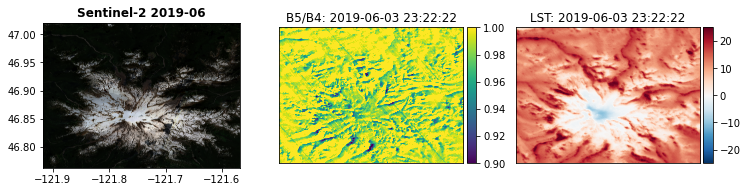

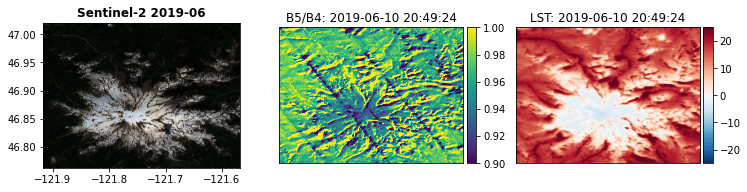

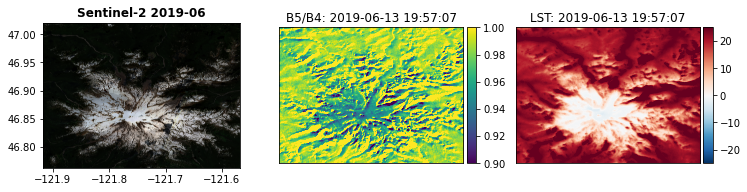

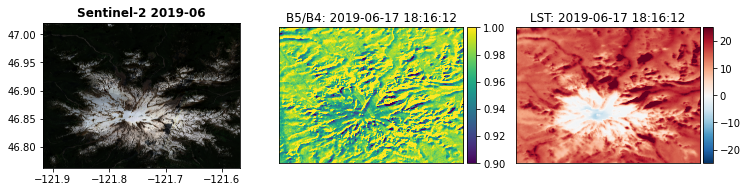

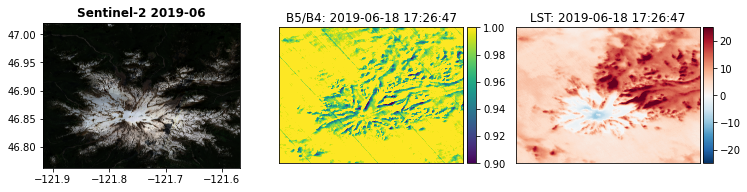

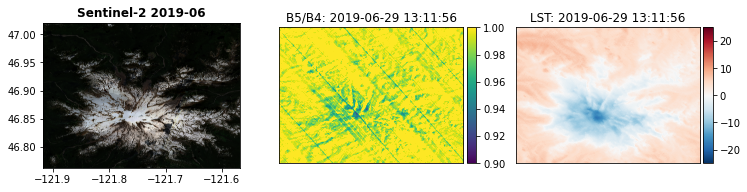

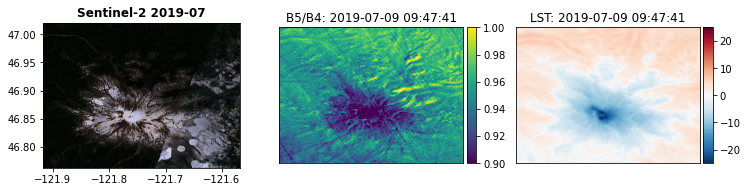

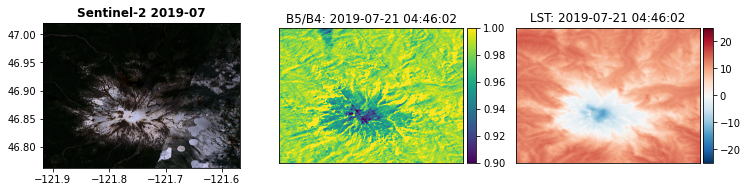

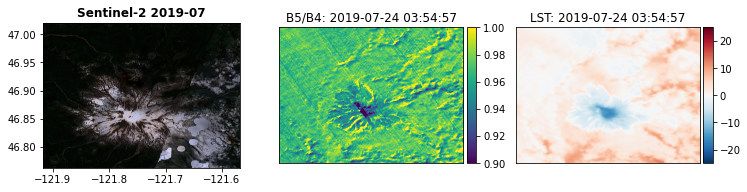

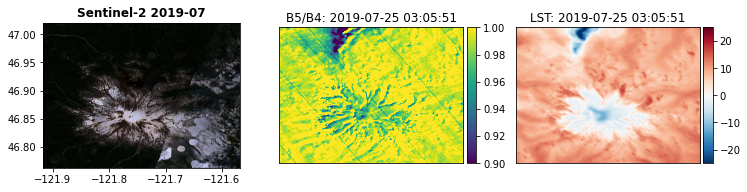

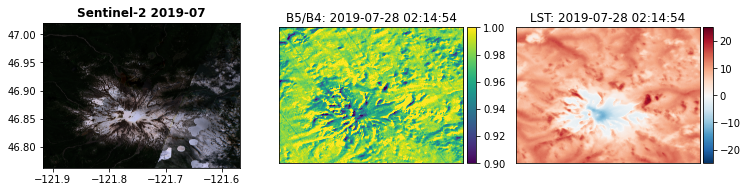

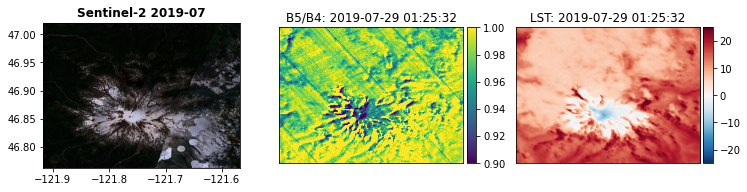

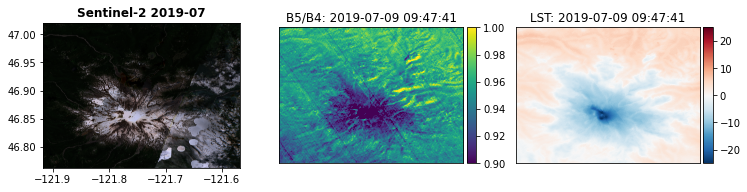

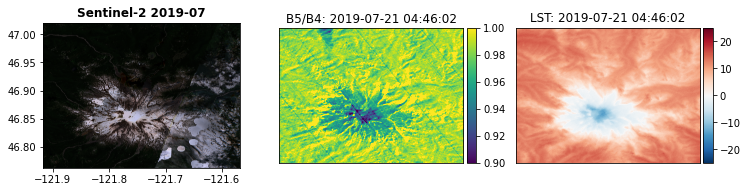

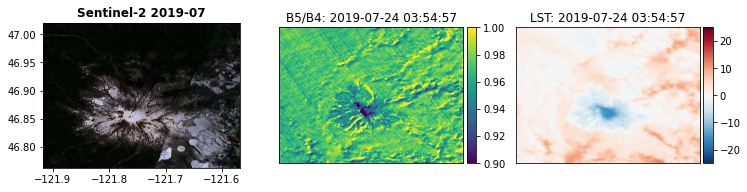

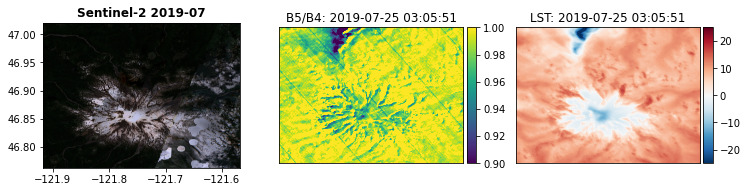

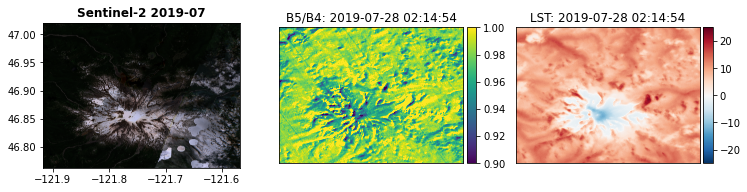

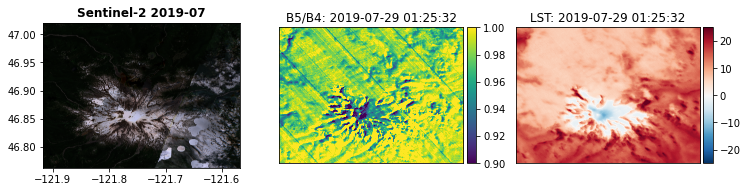

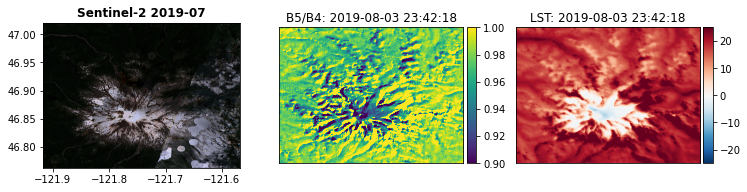

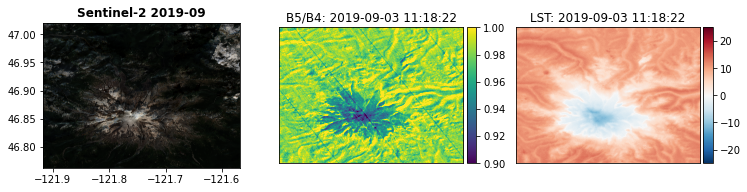

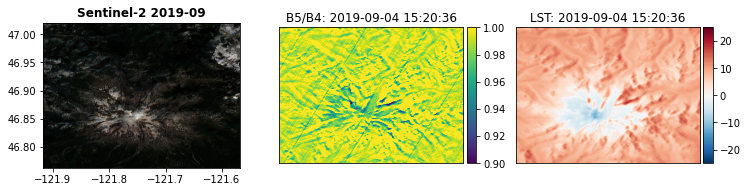

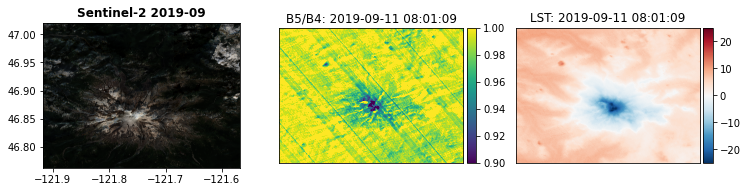

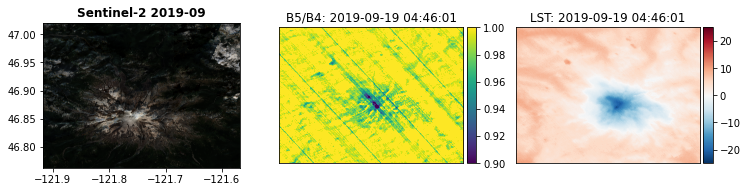

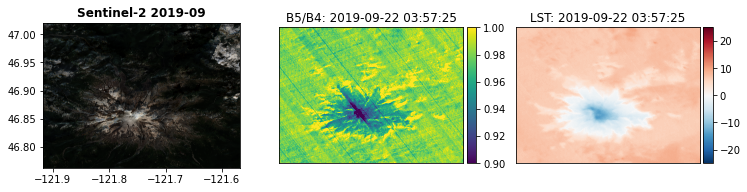

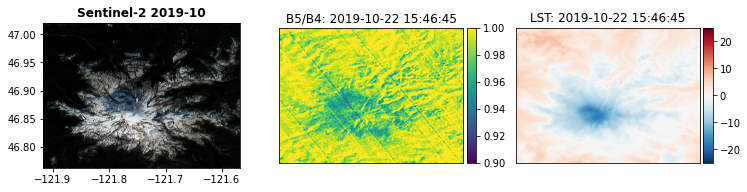

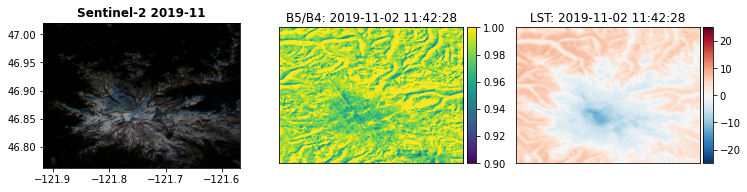

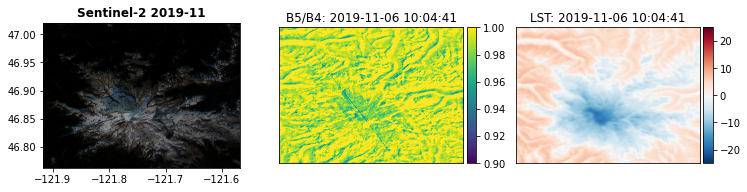

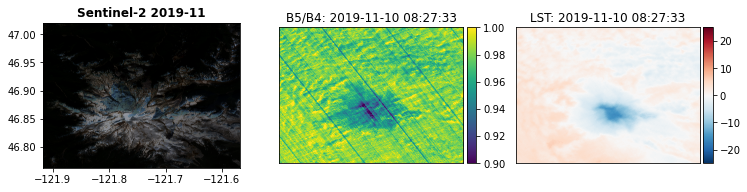

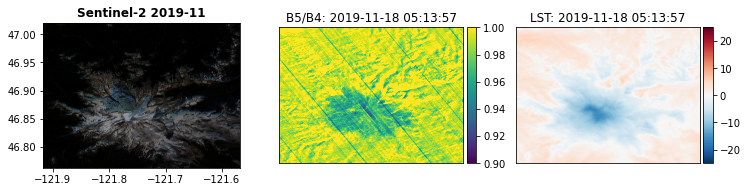

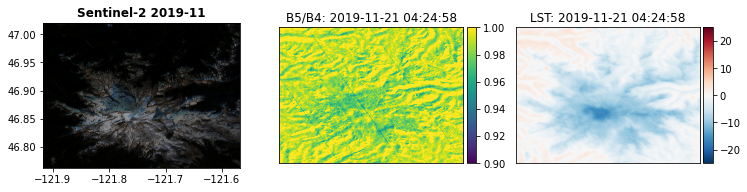

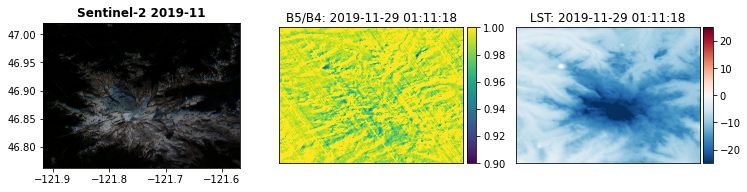

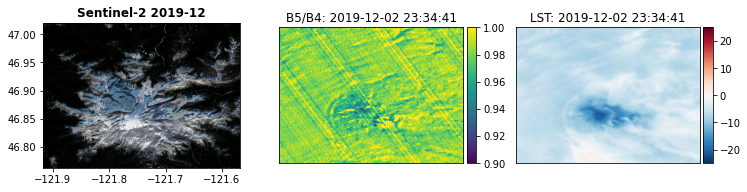

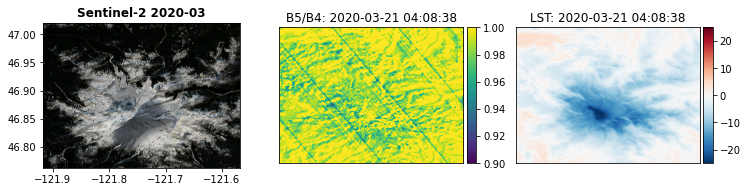

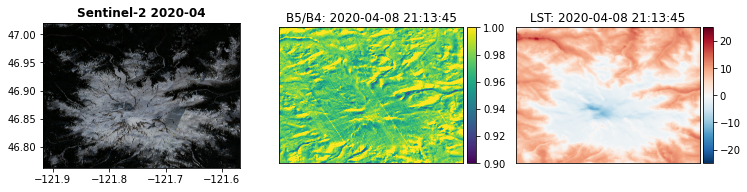

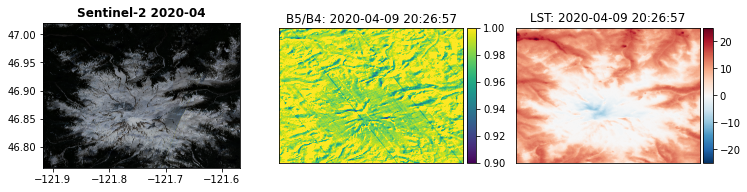

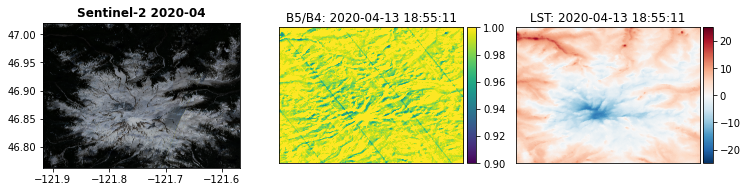

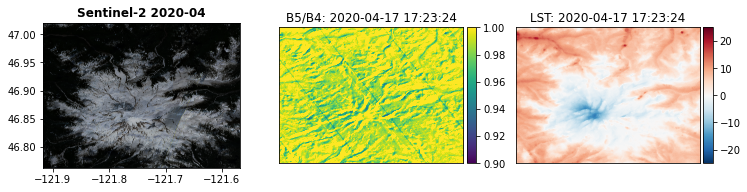

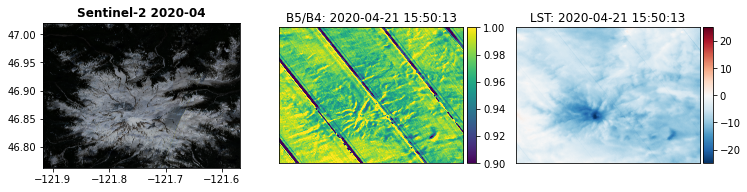

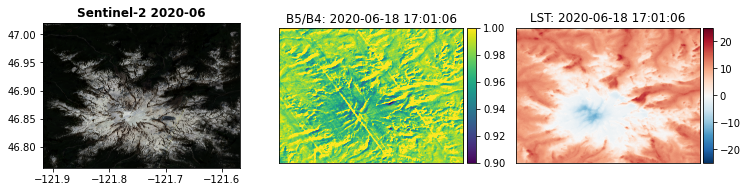

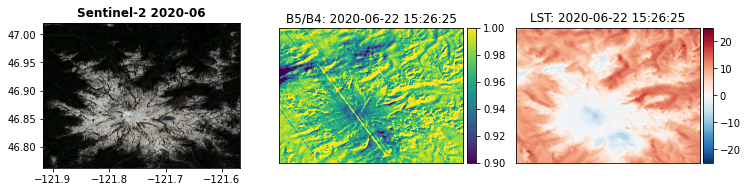

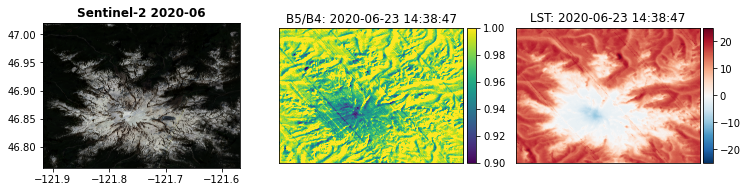

In [219]:
#Import, normalize, and plot the images


files = []
for f, s, d in os.walk(s2_imdir):
    d = sorted(d)
    for i in d:
        if '.tif' in i:
            files.append(i)

for idx, i in enumerate(files):
    path =  os.path.join(s2_imdir, i)
    img = rio.open(path)
# normalize
    bands = {}

    for b in [1,2,3]:
        band = np.nan_to_num(img.read(b))
        bands["band{0}".format(b)] = normalize(band) # preprocessing.normalize(i,'l1', axis=0)
    rgb = np.stack([bands['band1'], bands['band2'], bands['band3']])
# Get a list of the ECOSTRESS images in this month

    beg = pd.to_datetime(i.replace('.tif', '').split('T')[0])
    end = beg + relativedelta(months=1)
    try:
        eco_ims = qced[(qced['doy'] >= beg) & (qced['doy'] < end)]
        lst_ims = pd.DataFrame(eco_ims['images'].str.replace('ECO2LSTE.001_SDS_Emis5_', 'ECO2LSTE.001_SDS_LST_'))
        b4_ims = pd.DataFrame(eco_ims['images'].str.replace('ECO2LSTE.001_SDS_Emis5_', 'ECO2LSTE.001_SDS_Emis4_'))
        for idx, image in eco_ims.iterrows():

            band4 = rio.open(b4_ims.loc[idx]['images'])
            band5 = rio.open(image['images'])
            
            band5_r = band5.read()*0.002+0.49 
            band4_r = band4.read()*0.002+0.49 
            emis = band5_r/band4_r
            
            lst = rio.open(lst_ims.loc[idx]['images'])
            lst_scaled = (lst.read(1) *0.02) - 273
        
            
            fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=False)

            plot.show(rgb, transform = img.transform, title='Sentinel-2 '+str(i)[:7], ax=ax[0])

            img1 = ax[1].imshow(emis.reshape(band5_r.shape[1:]), cmap="viridis", vmin=0.9, vmax=1)#title='Band 5: '+str(image['doy'])
            img2 = ax[2].imshow(lst_scaled, cmap="RdBu_r", vmin=-25, vmax=25)

            colorbar(img1)
            colorbar(img2)

            ax[1].set_title('B5/B4: '+str(image['doy']))
            ax[2].set_title('LST: '+str(image['doy']))

            ax[1].tick_params(
                axis='both',         
                which='both',      
                left=False, 
                labelleft=False,
                bottom=False,
                labelbottom=False) 

            ax[2].tick_params(
                axis='both',         
                which='both',      
                left=False, 
                labelleft=False,
                bottom=False,
                labelbottom=False)  

            #plt.savefig('/Users/corey/Documents/GitHub/jpl_msp_2020/figures/'+str(image[1]['doy'])+'.tif', dpi=300)
            plt.show()

    except:
        pass
#        plt.title(str(i) +' mosaic')

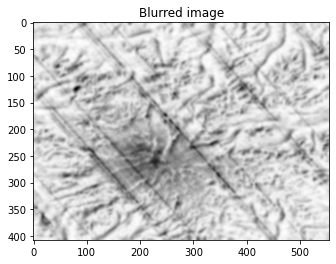

In [849]:
from scipy import ndimage
im_blur = ndimage.gaussian_filter(band5_r, 2)

plt.figure()
plt.imshow(im_blur.reshape(408, 555), plt.cm.gray)
plt.title('Blurred image')

plt.show()


In [ ]:
#PLot an LST error image

err = rio.open(os.path.join(imdir, 'ECO2LSTE.001_SDS_LST_err_doy2020147022835_aid0001.tif'))
s2 = rio.open(os.path.join(s2_imdir, '2020-05-01T00:00:00.tif'))

bands = {}

for b in [1,2,3]:
    band = np.nan_to_num(s2.read(b))
    bands["band{0}".format(b)] = normalize(band) # preprocessing.normalize(i,'l1', axis=0)
rgb = np.stack([bands['band1'], bands['band2'], bands['band3']])

date = pd.to_datetime('2020147022835', format='%Y%j%H%M%S')

fig, ax = plt.subplots(1,2, figsize=(8, 6))

plot.show(rgb, ax=ax[0], title='2020-05 Mosaic')

im = ax[1].imshow(err.read(1)*0.04)
plt.title(str(date))
eplot.colorbar(im)
plt.tight_layout()

#plt.savefig('/Users/corey/Documents/GitHub/jpl_msp_2020/figures/LST_error_example.tif', dpi=300)